# Importiere Daten


In [22]:
import numpy as np
import pandas as pd
import geopandas as gp
import xarray as xr
import datetime
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

## Funktionen definieren

In [44]:
def select_every_12th_with_start(arr, start_index):
    if start_index < 1 or start_index > 12:
        raise ValueError("Start index must be between 1 and 11")

    selected_elements = []
    for i in range(start_index - 1, len(arr), 12):
        selected_elements.append(arr[i])
    
    return selected_elements

def linear_reg(x, m, t):
    return m*x + t

def generate_counting_array(length):
    return np.arange(length)

    
def selecting_month(arr, start_index, start_date, end_date):
    if start_index < 1 or start_index > 12:
        raise ValueError("Start index must be between 1 and 12")  # Change 11 to 12

    selected_elements = []
    for i in range(start_index - 1, len(arr), 12):
        selected_elements.append(arr[i])

    tmp = xr.concat(selected_elements, dim="time")  # Concatenate the selected elements
    tmp = tmp.sel(time=slice(start_date, end_date))
    
    return tmp



## Daten importieren

In [24]:
# File paths
TMin_file = 'data/cru_ts4.07.1901.2022.tmn.dat.nc/cru_ts4.07.1901.2022.tmn.dat.nc'
TMax_file = 'data/cru_ts4.07.1901.2022.tmx.dat.nc/cru_ts4.07.1901.2022.tmx.dat.nc'
TAvg_file = 'data\cru_ts4.07.1901.2022.tmp.dat.nc\cru_ts4.07.1901.2022.tmp.dat.nc'

# Load datasets
TMin = xr.open_dataset(TMin_file)
TMax = xr.open_dataset(TMax_file)
TAvg =  xr.open_dataset(TAvg_file)

## Differenz berechnen

In [25]:
#Projeziert auf eine latitude

TMin_Lat = TMin.mean('lon')
TMax_Lat = TMax.mean('lon')
TAvg_Lat = TAvg.mean('lon')

In [26]:
time_values = TMax['time'].values

In [27]:
TMin_Lat_tot = TMin_Lat.sel(lat = slice(67,90)).mean('lat')
TMax_Lat_tot = TMax_Lat.sel(lat = slice(67,90)).mean('lat')
TAvg_Lat_tot = TAvg_Lat.sel(lat = slice(67,90)).mean('lat')



In [28]:
temperature_difference = TMax.tmx - TMin.tmn   # Normale Differenz fü jeden Punkt
temperature_difference_Lat = TMax_Lat.tmx- TMin_Lat.tmn # Creating lateral difference
temperature_difference_Pol = TMax_Lat_tot.tmx- TMin_Lat_tot.tmn

## Plots

### Delta T

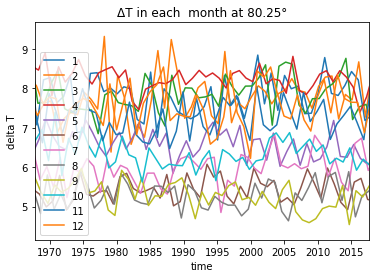

In [29]:
lat = 80.75

# Define the variables time_values and temperature_difference_Lat here

for month in range(1, 13):
    plt.plot(
        select_every_12th_with_start(time_values, month),
        select_every_12th_with_start(temperature_difference_Lat.sel(lat=str(lat)), month),
        label= str(month)
    )

plt.xlabel('time')
plt.ylabel('delta T')
plt.title('ΔT in each  month at 80.25°')

# Uncomment these lines if needed
plt.xlim(time_values[800], time_values[1400])
plt.legend(loc=3)

# plt.tight_layout()
# plt.savefig(f'Delta_T_Month_{month}.png', dpi=300)
# plt.clf()

plt.show()  # Display the plot


Text(0.5, 1.0, 'Mean Delta T for month at 80.25°')

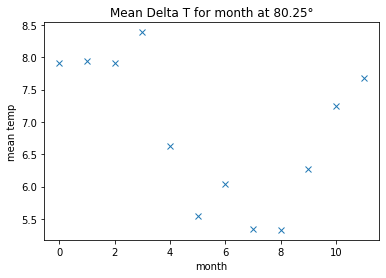

In [30]:
#Calculating the mean values for Delta T

lat = 80.25

mean_month =  np.array([[1, np.mean(select_every_12th_with_start(temperature_difference_Lat.sel(lat=str(lat)), 1))]])

for month in range(2,13):
    mean_month = np.vstack((mean_month,np.array([[month,np.mean(select_every_12th_with_start(temperature_difference_Lat.sel(lat=str(lat)), month))]])) )

plt.plot(mean_month[:,1], ls = '', marker = 'x')

plt.xlabel('month')
plt.ylabel('mean temp')

plt.title('Mean Delta T for month at 80.25°')

Text(0.5, 1.0, 'Mean Delta T for month at 66.25°')

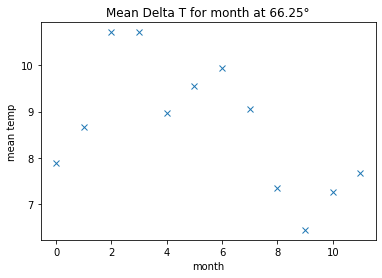

In [31]:
#Calculating the mean values for Delta T
lat = 66.25

mean_month =  np.array([[1, np.mean(select_every_12th_with_start(temperature_difference_Lat.sel(lat=str(lat)), 1))]])

for month in range(2,13):
    mean_month = np.vstack((mean_month,np.array([[month,np.mean(select_every_12th_with_start(temperature_difference_Lat.sel(lat=str(lat)), month))]])) )

plt.plot(mean_month[:,1], ls = '', marker = 'x')

plt.xlabel('month')
plt.ylabel('mean temp')

plt.title('Mean Delta T for month at 66.25°')

### Plot Minimaltemperaturen

### Poly Fit Delta T


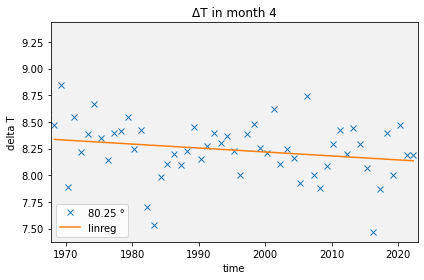

In [32]:
# Nach Jahreszeiten selektiert Januar
month = 4

lat = 80.25


paramet_fit_month4_lat8025, cov_month4_lat8025 = curve_fit(linear_reg, generate_counting_array(len(select_every_12th_with_start(time_values,month)[67:])), select_every_12th_with_start(temperature_difference_Lat.sel(lat = str(lat)),month)[67:])

#print(type(generate_counting_array(len(select_every_12th_with_start(time_values,month)[67:]))[0]))

generate_counting_array(len(select_every_12th_with_start(time_values,month)[67:]))* paramet_fit_month4_lat8025[0]


ydata_temp = linear_reg(generate_counting_array(len(select_every_12th_with_start(time_values,month)[67:])), *paramet_fit_month4_lat8025)
plt.plot(select_every_12th_with_start(time_values,month), select_every_12th_with_start(temperature_difference_Lat.sel(lat = str(lat)),month),marker = 'x', ls = '', label = str(lat)+' °')

plt.plot(select_every_12th_with_start(time_values,month)[67:], ydata_temp, label = 'linreg')

#Calculating varriance

VarDeltaT = np.var(select_every_12th_with_start(temperature_difference_Lat.sel(lat = str(lat)),month)[67:]-ydata_temp)


plt.xlabel('time')
plt.ylabel('delta T')

plt.title('ΔT in month ' + str(month))

plt.xlim(time_values[800], time_values[-1])
plt.legend(loc = 3)
# Add a subtle background color
plt.gca().set_facecolor((0.95, 0.95, 0.95))

# Display the plot
plt.tight_layout()
# plt.savefig('LinReg_Delta_T.png', dpi = 300)
plt.show()

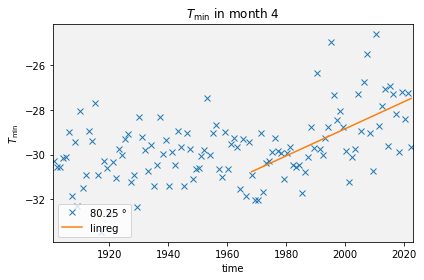

In [33]:
# Parameter setzen

month = 4
lat = 80.25

#Fitten

paramet_fit_month4_lat8025_minTemP, cov_month4_lat8025_MinTemp = curve_fit(linear_reg, generate_counting_array(len(select_every_12th_with_start(time_values,month)[67:])), select_every_12th_with_start(TMin_Lat.sel(lat = str(lat)).tmn,month)[67:])

#Plots vorbereiten

ydata_temp = linear_reg(generate_counting_array(len(select_every_12th_with_start(time_values,month)[67:])), *paramet_fit_month4_lat8025_minTemP)

#Calculating Var

VarTMin = np.var(select_every_12th_with_start(TMin_Lat.sel(lat = str(lat)).tmn,month)[67:] -ydata_temp)

#Plotten

plt.plot(select_every_12th_with_start(time_values,month), select_every_12th_with_start(TMin_Lat.sel(lat = str(lat)).tmn,month),marker = 'x', ls = '', label = str(lat)+' °')
plt.plot(select_every_12th_with_start(time_values,month)[67:], ydata_temp, label = 'linreg')

#Formatieren

plt.xlabel('time')
plt.ylabel('$T_{\mathrm{min}}$')

plt.title('$T_{\mathrm{min}}$ in month ' + str(month))

plt.xlim(time_values[0], time_values[-1])
plt.legend(loc = 3)

# Add a subtle background color
plt.gca().set_facecolor((0.95, 0.95, 0.95))

# Display the plot
plt.tight_layout()
# plt.savefig('LinReg_T_min.png', dpi = 300)
plt.show()

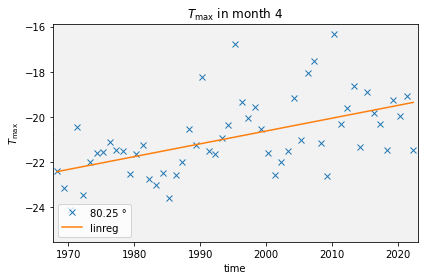

In [34]:
# Parameter setzen

month = 4
lat = 80.25

#Fitten

paramet_fit_month4_lat8025_maxTemP, cov_month4_lat8025_MaxTemp = curve_fit(linear_reg, generate_counting_array(len(select_every_12th_with_start(time_values,month)[67:])), select_every_12th_with_start(TMax_Lat.sel(lat = str(lat)).tmx,month)[67:])

#Plots vorbereiten

ydata_temp = linear_reg(generate_counting_array(len(select_every_12th_with_start(time_values,month)[67:])), *paramet_fit_month4_lat8025_maxTemP)


#Calculating Var

VarTMax = np.var(select_every_12th_with_start(TMax_Lat.sel(lat = str(lat)).tmx,month)[67:] -ydata_temp)

#Plotten

plt.plot(select_every_12th_with_start(time_values,month), select_every_12th_with_start(TMax_Lat.sel(lat = str(lat)).tmx,month),marker = 'x', ls = '', label = str(lat)+' °')
plt.plot(select_every_12th_with_start(time_values,month)[67:], ydata_temp, label = 'linreg')

#Formatieren

plt.xlabel('time')
plt.ylabel('$T_{\mathrm{max}}$')

plt.title('$T_{\mathrm{max}}$ in month ' + str(month))

plt.xlim(time_values[800], time_values[-1])
plt.legend(loc = 3)

# Add a subtle background color
plt.gca().set_facecolor((0.95, 0.95, 0.95))

# Display the plot
plt.tight_layout()
# plt.savefig('LinReg_T_max.png', dpi = 300)
plt.show()

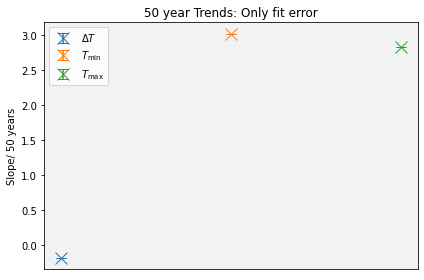

In [35]:
#Plot

# Data for the points
pos = np.array([1, 2, 3])
slope = np.array([paramet_fit_month4_lat8025[0] , paramet_fit_month4_lat8025_minTemP[0], paramet_fit_month4_lat8025_maxTemP[0]])*50

# Error bars for the points
x_err = None
y_err = np.array([cov_month4_lat8025[0,0], cov_month4_lat8025_MinTemp[0,0], cov_month4_lat8025_MaxTemp[0,0]])*2.5

# cov_month4_lat8025_MinTemp
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the points with error bars
ax.errorbar(pos[0], slope[0], xerr=x_err, yerr=y_err[0], fmt='x', markersize=12, capsize=5, label='$\Delta T$')
ax.errorbar(pos[1], slope[1], xerr=x_err, yerr=y_err[1], fmt='x', markersize=12, capsize=5, label='$T_{\mathrm{min}}$')
ax.errorbar(pos[2], slope[2], xerr=x_err, yerr=y_err[2], fmt='x', markersize=12, capsize=5, label='$T_{\mathrm{max}}$')
# Add labels and title
# ax.set_xlabel('X-axis')
plt.xticks([])  # Empty list for tick labels, tick marks remain visible

ax.set_ylabel('Slope/ 50 years')
ax.set_title('50 year Trends: Only fit error')

# Add legend
ax.legend()

# Add a subtle background color
plt.gca().set_facecolor((0.95, 0.95, 0.95))

# Display the plot
plt.tight_layout()
# plt.savefig('50YearSlope_fiterror.png', dpi = 300)
plt.show()

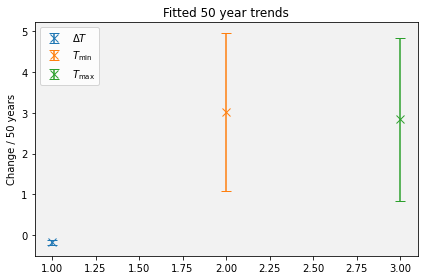

In [36]:
#Plot

# Data for the points
pos = np.array([1, 2, 3])
slope = np.array([paramet_fit_month4_lat8025[0] , paramet_fit_month4_lat8025_minTemP[0], paramet_fit_month4_lat8025_maxTemP[0]])*50

# Error bars for the points
x_err = None
y_err = np.array([VarDeltaT, VarTMin, VarTMax])

# cov_month4_lat8025_MinTemp
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the points with error bars
ax.errorbar(pos[0], slope[0], xerr=x_err, yerr=y_err[0], fmt='x', markersize=8, capsize=5, label='$\Delta T$')
ax.errorbar(pos[1], slope[1], xerr=x_err, yerr=y_err[1], fmt='x', markersize=8, capsize=5, label='$T_{\mathrm{min}}$')
ax.errorbar(pos[2], slope[2], xerr=x_err, yerr=y_err[2], fmt='x', markersize=8, capsize=5, label='$T_{\mathrm{max}}$')
# Add labels and title
# ax.set_xlabel('X-axis')
ax.set_ylabel('Change / 50 years')

ax.set_title('Fitted 50 year trends')

# Add legend
ax.legend()

# Add a subtle background color
plt.gca().set_facecolor((0.95, 0.95, 0.95))

# Display the plot
plt.tight_layout()
# plt.savefig('50yearSlope_numErr.png',dpi = 300)
plt.show()

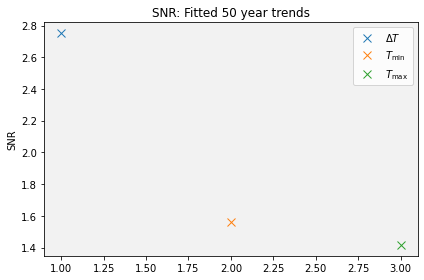

In [37]:
# SNR

y_err = np.array([VarDeltaT, VarTMin, VarTMax])
slope = np.array([paramet_fit_month4_lat8025[0] , paramet_fit_month4_lat8025_minTemP[0], paramet_fit_month4_lat8025_maxTemP[0]])*50

SNR = np.divide(slope, y_err)

plt.plot(pos[0],-SNR[0], marker='x', markersize=8, ls = '',  label='$\Delta T$')
plt.plot(pos[1], SNR[1], marker='x', markersize=8, ls = '',   label='$T_{\mathrm{min}}$')
plt.plot(pos[2], SNR[2], marker='x', markersize=8, ls = '',   label='$T_{\mathrm{max}}$')
# ax.errorbar(pos[1], slope[1], xerr=x_err, yerr=y_err[1], fmt='x', markersize=8, capsize=5, label='$T_{\mathrm{min}}$')
# ax.errorbar(pos[2], slope[2], xerr=x_err, yerr=y_err[2], fmt='x', markersize=8, capsize=5, label='$T_{\mathrm{max}}$')
# Add labels and title
# ax.set_xlabel('X-axis')
plt.ylabel('SNR')

plt.title('SNR: Fitted 50 year trends')

# Add legend
plt.legend()

# Add a subtle background color
plt.gca().set_facecolor((0.95, 0.95, 0.95))

# Display the plot
plt.tight_layout()
#plt.savefig('50yearSlope_SNR.png',dpi = 300)
plt.show()

In [43]:
time_values[0]
t1 = '1973-01-15T00:00:00.000000000'

# def selecting_month_test(arr, month, start_date, end_date):
#     if start_index < 1 or start_index > 12:
#         raise ValueError("Start index must be between 1 and 11")

#     selected_elements = []
#     for i in range(start_index - 1, len(arr), 12):
#         selected_elements.append(arr[i])
#         tmp = selected_elements.sel(time = slice(start_date, end_date))
#     return tmp

selecting_month2(temperature_difference_Lat.sel(lat = str(lat)),4, t1, time_values[-1])

<xarray.DataArray (time: 50)>
array([8.38694  , 8.667118 , 8.345495 , 8.141443 , 8.397749 , 8.415318 ,
       8.545496 , 8.245043 , 8.420269 , 7.6986485, 7.535589 , 7.981531 ,
       8.101351 , 8.2027   , 8.099102 , 8.227932 , 8.456301 , 8.148201 ,
       8.269819 , 8.397747 , 8.29775  , 8.370722 , 8.229279 , 8.001799 ,
       8.386034 , 8.480633 , 8.256308 , 8.210815 , 8.617117 , 8.104055 ,
       8.241442 , 8.162613 , 7.927929 , 8.740091 , 8.002253 , 7.8770275,
       8.082434 , 8.292345 , 8.427479 , 8.197298 , 8.442343 , 8.290543 ,
       8.063963 , 7.46937  , 7.875223 , 8.395498 , 7.9981956, 8.475674 ,
       8.1914425, 8.191444 ], dtype=float32)
Coordinates:
    lat      float32 80.25
  * time     (time) datetime64[ns] 1973-04-16 1974-04-16 ... 2022-04-16

### Loops Fit

In [46]:
def fit_count(arr):
    return 

def linReg_all_month():
    for month in range(1,13):
        par_LinReg, cov_LinReg = curve_fit(linear_reg, generate_counting_array(len(select_every_12th_with_start(time_values,month)[67:])), select_every_12th_with_start(temperature_difference_Lat.sel(lat = str(lat)),month)[67:])






# Nach Jahreszeiten selektiert Januar
month = 4

lat = 80.25


paramet_fit_month4_lat8025, cov_month4_lat8025 = curve_fit(linear_reg, generate_counting_array(len(select_every_12th_with_start(time_values,month)[67:])), select_every_12th_with_start(temperature_difference_Lat.sel(lat = str(lat)),month)[67:])

#print(type(generate_counting_array(len(select_every_12th_with_start(time_values,month)[67:]))[0]))

generate_counting_array(len(select_every_12th_with_start(time_values,month)[67:]))* paramet_fit_month4_lat8025[0]


ydata_temp = linear_reg(generate_counting_array(len(select_every_12th_with_start(time_values,month)[67:])), *paramet_fit_month4_lat8025)
plt.plot(select_every_12th_with_start(time_values,month), select_every_12th_with_start(temperature_difference_Lat.sel(lat = str(lat)),month),marker = 'x', ls = '', label = str(lat)+' °')

plt.plot(select_every_12th_with_start(time_values,month)[67:], ydata_temp, label = 'linreg')

#Calculating varriance

VarDeltaT = np.var(select_every_12th_with_start(temperature_difference_Lat.sel(lat = str(lat)),month)[67:]-ydata_temp)


plt.xlabel('time')
plt.ylabel('delta T')

plt.title('ΔT in month ' + str(month))

plt.xlim(time_values[800], time_values[-1])
plt.legend(loc = 3)
# Add a subtle background color
plt.gca().set_facecolor((0.95, 0.95, 0.95))

# Display the plot
plt.tight_layout()
# plt.savefig('LinReg_Delta_T.png', dpi = 300)
plt.show()

IndentationError: expected an indented block after function definition on line 1 (4028270837.py, line 3)

### Hearmap

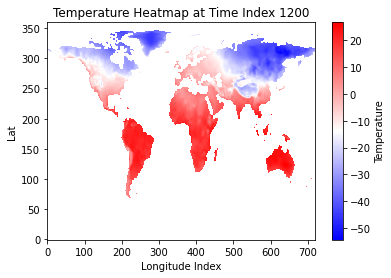

In [39]:
time_index = 1200
temperature_data = TMin.isel(time=time_index).tmn#,lon = range(0,260), lat = range(330,360)).tmn

plt.imshow(temperature_data, cmap='bwr', origin='lower', aspect='auto')
plt.colorbar(label='Temperature')
plt.title(f'Temperature Heatmap at Time Index {time_index}')
plt.xlabel('Longitude Index')
plt.ylabel('Lat')
plt.show()